#### _Matin's Lab Rotation 3 - BCFO_ | [NEXT](01-1_simulation_isobutyric_strain.ipynb) | [PREVIOUS](00-1_build_strain.ipynb)
# 03. Simulation of the Xylitol Producing Strain

## Load Library

In [1]:
from cameo import load_model
from cameo import fba
from escher import Builder
import pandas as pd
import cobra

/home/matinnu/anaconda3/envs/lab_rotation_3/lib/python3.7/site-packages/sympy/__init__.py:676: SymPyDeprecationWarning: 

importing sympy.core.singleton with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.core.singleton instead.
See https://github.com/sympy/sympy/issues/18245 for more info.

  deprecated_since_version="1.6").warn()


In [2]:
def simulate_model(experiment_id, model, objective, target, metabolite):
    model.objective = objective
    solution = fba(model)
    f_data = solution.fluxes
    f_data = f_data.rename(experiment_id)
    solution_result = []
    for i in target:
        flux = solution.fluxes.get(i)
        solution_result.append(flux)
    data = [experiment_id] + solution_result
    #print(data)
    df_target = pd.DataFrame(columns=[["Model"]+target], data=[data])
    print("experiment:", experiment_id, "| evaluate compound:", model.metabolites.get_by_id(metabolite).summary())
    return df_target, f_data

def run_series_simulation(experiment, model, mutant, target, metabolite):
    solution_fluxes = pd.DataFrame()
    df = pd.DataFrame()
    for i in experiment.index:
        experiment_id = experiment.loc[i, "experiment_id"]
        if experiment.loc[i, "model_id"] != "model":
            m = mutant
        else:
            m = model
        objective = experiment.loc[i, "objective"]
        data, sol = simulate_model(experiment_id, m, objective, target, metabolite)
        solution_fluxes = solution_fluxes.append(sol)
        df = df.append(data)
        print("****************************************", "\n")
    return df, solution_fluxes

def visualize_flux(model, objective, map_data='map/iJO1366.Central metabolism_rotation3.json'):
    model.objective = objective
    flux = fba(model).fluxes
    builder = Builder(
        map_json = map_data,
        reaction_data = flux
    )
    return flux, builder

def crispri(mutant, status):
    if status == "on":
        mutant.reactions.get_by_id("CYTBDpp").knock_out()
    else:
        mutant.reactions.get_by_id("CYTBDpp").bounds = (0.0, 1000.0)
    print("CYTBDpp: "+str(mutant.reactions.get_by_id("CYTBDpp").bounds))
    return mutant

## Load Model

In [3]:
# WT for comparison
model1 = load_model('iML1515')
model1.solver = 'gurobi'
model1

Using license file /home/matinnu/gurobi.lic
Academic license - for non-commercial use only


Name,iML1515
Memory address,0x07f830deb3c90
Number of metabolites,1877
Number of reactions,2712
Number of groups,0
Objective expression,0.0 + 1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"cytosol, extracellular space, periplasm"


In [4]:
# load mutant
mutant = load_model('result/iML1515_xylitol_strain.xml')
mutant.solver = 'gurobi'
mutant

Name,iML1515_xy_obj
Memory address,0x07f830fd08f10
Number of metabolites,1880
Number of reactions,2715
Number of groups,0
Objective expression,0.0 + 0.7*BIOMASS_Ec_iML1515_core_75p37M - 0.7*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685 + 0.0...
Compartments,"cytosol, extracellular space, periplasm"


## Define Media: Glucose & Xylose

In [45]:
# define media composition
media_components = [["EX_xyl__D_e", 75],
                    ["EX_glc__D_e", 75],
                    ["EX_o2_e", 1000]
                   ]

# change the media in the model
medium = model1.medium
for i in media_components:
    medium[i[0]] = i[1]
    model1.medium = medium
#print(model.medium)

# change the media in the mutant
medium = mutant.medium
for i in media_components:
    medium[i[0]] = i[1]
    mutant.medium = medium
#print(mutant.medium)

# WT Grow on Glu & Xyl

## WT Biomass Objective

In [46]:
f1, b = visualize_flux(model1, "BIOMASS_Ec_iML1515_core_75p37M")
b

Builder(reaction_data={'CYTDK2': 0.0, 'XPPT': 0.0, 'HXPRT': 0.0, 'NDPK5': 0.0, 'SHK3Dr': 4.694317150155134, 'N…

## WT under Anaerobic Condition

In [47]:
media_components = [["EX_o2_e", 0]]
medium = model1.medium
for i in media_components:
    medium[i[0]] = i[1]
    model1.medium = medium
f2, b = visualize_flux(model1, "BIOMASS_Ec_iML1515_core_75p37M")
b

Builder(reaction_data={'CYTDK2': 0.0, 'XPPT': 0.0, 'HXPRT': 0.0, 'NDPK5': 0.0, 'SHK3Dr': 1.0530086306905462, '…

# Mutant Growth on Glu & Xyl
## Mt Growth Objective

In [48]:
f3, b = visualize_flux(crispri(mutant, "off"), "BIOMASS_Ec_iML1515_core_75p37M")
b

CYTBDpp: (0.0, 1000.0)


Builder(reaction_data={'CYTDK2': 0.0, 'XPPT': 0.0, 'HXPRT': 0.0, 'NDPK5': 0.0, 'SHK3Dr': 2.299051496444827, 'N…

In [49]:
f4, b = visualize_flux(crispri(mutant, "on"), "BIOMASS_Ec_iML1515_core_75p37M")

CYTBDpp: (0, 0)


## Mt Xylitol Objective

In [50]:
f5, b = visualize_flux(crispri(mutant, "off"), "EX_xylt_e")
b

CYTBDpp: (0.0, 1000.0)


Builder(reaction_data={'CYTDK2': 0.0, 'XPPT': 0.0, 'HXPRT': 0.0, 'NDPK5': 0.07397793330128391, 'SHK3Dr': 1.043…

In [51]:
f6, b = visualize_flux(crispri(mutant, "on"), "EX_xylt_e")
b

CYTBDpp: (0, 0)


Builder(reaction_data={'CYTDK2': 0.0, 'XPPT': 0.0, 'HXPRT': 0.0, 'NDPK5': 0.07397793330128358, 'SHK3Dr': 1.043…

## Mt Xylitol+Acetate Objective

In [52]:
reaction_1 = mutant.reactions.get_by_id('BIOMASS_Ec_iML1515_core_75p37M')
#reaction_1 = mutant.reactions.get_by_id('ATPM')
reaction_2 = mutant.reactions.get_by_id('EX_xylt_e')
reaction_3 = mutant.reactions.get_by_id('EX_ac_e')

new_objective = {reaction_1: 0.7, reaction_2:0.29, reaction_3: 0.01}
f7, b = visualize_flux(crispri(mutant, "off"), new_objective)
b

CYTBDpp: (0.0, 1000.0)


Builder(reaction_data={'CYTDK2': 0.0, 'XPPT': 0.0, 'HXPRT': 0.0, 'NDPK5': 0.0, 'SHK3Dr': 2.0743909927680764, '…

In [53]:
mutant.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.02833,0,0.00%
cl_e,EX_cl_e,0.02833,0,0.00%
cobalt2_e,EX_cobalt2_e,0.0001361,0,0.00%
cu2_e,EX_cu2_e,0.003859,0,0.00%
fe2_e,EX_fe2_e,0.08742,0,0.00%
glc__D_e,EX_glc__D_e,75,6,54.55%
k_e,EX_k_e,1.062,0,0.00%
mg2_e,EX_mg2_e,0.04722,0,0.00%
mn2_e,EX_mn2_e,0.003761,0,0.00%
mobd_e,EX_mobd_e,3.81E-05,0,0.00%


In [54]:
mutant.id = mutant.id+"_xy_strain_crispr_off"
cobra.io.write_sbml_model(mutant, "result/model_for_consortia/iML1515_xylitol_strain_crispr_off.xml")
cobra.io.save_json_model(mutant, "result/model_for_consortia/iML1515_xylitol_strain_crispr_off.json")
mutant.metabolites.ac_c.summary()

Percent,Flux,Reaction,Definition
50.81%,1.61,ACODA,acorn_c + h2o_c --> ac_c + orn_c
42.51%,1.347,CYSS,acser_c + h2s_c --> ac_c + cys__L_c + h_c
6.68%,0.2118,UHGADA,h2o_c + u3aga_c --> ac_c + u3hga_c
Percent,Flux,Reaction,Definition
100.00%,-3.169,ACKr,ac_c + atp_c <=> actp_c + adp_c


In [55]:
f8, b = visualize_flux(crispri(mutant, "on"), new_objective)
b

CYTBDpp: (0, 0)


Builder(reaction_data={'CYTDK2': 0.0, 'XPPT': 0.0, 'HXPRT': 0.0, 'NDPK5': -0.08725254557759557, 'SHK3Dr': 1.27…

In [56]:
mutant.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.01736,0,0.00%
cl_e,EX_cl_e,0.01736,0,0.00%
cobalt2_e,EX_cobalt2_e,8.336E-05,0,0.00%
cu2_e,EX_cu2_e,0.002364,0,0.00%
fe2_e,EX_fe2_e,0.05356,0,0.00%
glc__D_e,EX_glc__D_e,75,6,54.55%
k_e,EX_k_e,0.6509,0,0.00%
mg2_e,EX_mg2_e,0.02893,0,0.00%
mn2_e,EX_mn2_e,0.002304,0,0.00%
mobd_e,EX_mobd_e,2.334E-05,0,0.00%


In [57]:
mutant.metabolites.ac_c.summary()

Percent,Flux,Reaction,Definition
97.56%,78.43,ACKr,ac_c + atp_c <=> actp_c + adp_c
1.23%,0.9863,ACODA,acorn_c + h2o_c --> ac_c + orn_c
0.02%,0.01736,ACt4pp,ac_p + na1_p --> ac_c + na1_c
1.03%,0.8252,CYSS,acser_c + h2s_c --> ac_c + cys__L_c + h_c
0.16%,0.1298,UHGADA,h2o_c + u3aga_c --> ac_c + u3hga_c
Percent,Flux,Reaction,Definition
100.00%,-80.39,ACt2rpp,ac_p + h_p <=> ac_c + h_c


In [184]:
experiment = ["wt_biomass", "wt_biomass_anaerobic", "mt_biomass_off", "mt_biomass_on", "mt_xylitol_off", "mt_xylitol_on", "mt_xyl+ace_off", "mt_xyl+ace_on"]
flux_data_all = pd.DataFrame(data=[f1, f2, f3, f4, f5, f6, f7, f8])
flux_data_all.index = experiment
flux_data_all.fillna(0)
flux_data_all.reset_index(inplace=True)

# new data frame with split value columns 
new = flux_data_all["index"].str.split("_", n = 1, expand = True) 
  
# making separate first name column from new data frame 
flux_data_all["Strain"]= new[0] 
  
# making separate last name column from new data frame 
flux_data_all["Experiment"]= new[1] 
  
# Dropping old Name columns 
#flux_data_all.drop(columns =["index"], inplace = True)
flux_data_all.index = experiment
flux_data_all

,index,CYTDK2,XPPT,HXPRT,NDPK5,SHK3Dr,NDPK6,NDPK8,DHORTS,OMPDC,...,MPTS,MOCOS,BMOGDS2,FESD2s,OCTNLL,XYLR,XYLTt,EX_xylt_e,Strain,Experiment
wt_biomass,wt_biomass,0.0,0.0,0.0,0.000000,4.694317,0.000000,-0.322292,-4.074467,4.074467,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,wt,biomass
wt_biomass_anaerobic,wt_biomass_anaerobic,0.0,0.0,0.0,0.000000,1.053009,0.000000,0.000000,-0.913966,0.913966,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,wt,biomass_anaerobic
mt_biomass_off,mt_biomass_off,0.0,0.0,0.0,0.000000,2.299051,0.000000,0.000000,-1.995478,1.995478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mt,biomass_off
mt_biomass_on,mt_biomass_on,0.0,0.0,0.0,0.133893,1.888781,0.129676,0.129676,-1.639381,1.639381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mt,biomass_on
mt_xylitol_off,mt_xylitol_off,0.0,0.0,0.0,0.073978,1.043580,0.071648,0.071648,-0.905783,0.905783,...,0.0,0.0,0.0,0.0,0.0,75.0,-75.0,75.0,mt,xylitol_off
mt_xylitol_on,mt_xylitol_on,0.0,0.0,0.0,0.073978,1.043580,0.071648,0.071648,-0.905783,0.905783,...,0.0,0.0,0.0,0.0,0.0,75.0,-75.0,75.0,mt,xylitol_on
mt_xyl+ace_off,mt_xyl+ace_off,0.0,0.0,0.0,0.000000,2.074391,0.000000,0.000000,-1.800483,1.800483,...,0.0,0.0,0.0,0.0,0.0,75.0,-75.0,75.0,mt,xyl+ace_off
mt_xyl+ace_on,mt_xyl+ace_on,0.0,0.0,0.0,-0.087253,1.270871,0.000000,0.000000,-1.103061,1.103061,...,0.0,0.0,0.0,0.0,0.0,75.0,-75.0,75.0,mt,xyl+ace_on


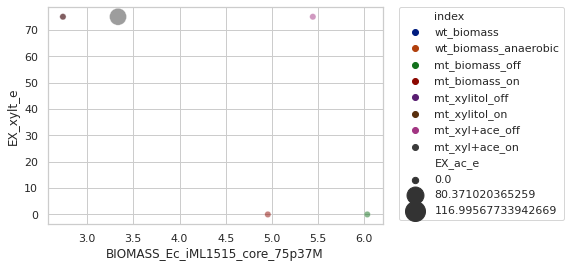

In [192]:
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
sns.color_palette("pastel")
#flux_data_all.rename(columns = {'index':'experiment'})
sns_plot = sns.scatterplot(size = "EX_ac_e",
                y = "EX_xylt_e",
                x = "BIOMASS_Ec_iML1515_core_75p37M",
                hue = "index",
                #style = "Strain",
                sizes=(40, 400), 
                alpha=.5, 
                palette="dark",
               data=flux_data_all)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig = sns_plot.get_figure()
fig.savefig("output.png")

In [151]:
df_heatmap = flux_data_all.loc[:, ["BIOMASS_Ec_iML1515_core_75p37M", "EX_glc__D_e", "EX_xyl__D_e", "EX_ac_e", "EX_xylt_e"]]#, "ACKr", "ACODA", "ACt4pp", "CYSS", "UHGADA", "ACt2rpp"]]

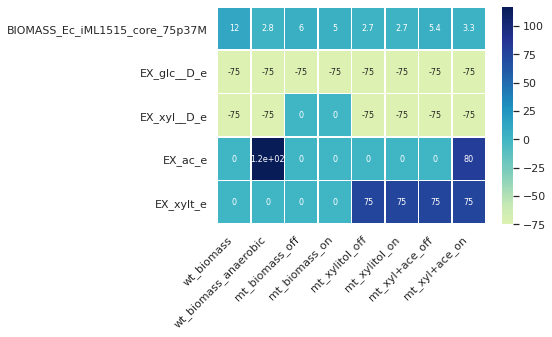

In [188]:
df_heatmap.index = experiment
g = sns.heatmap(df_heatmap.fillna(0).transpose(), 
                center=0, linewidths=.5, annot=True, cmap="YlGnBu", annot_kws={"fontsize":8})
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
fig = g.get_figure()
fig.savefig("heatmap.png")